## Fluxes through boundaries

This notebook looks at what things are going in and out of all my boundaries. N,S,E,W periodic and open.

In [2]:
from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [3]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import TransportTools_MITgcm as trt

In [4]:
def TotalTracerInDomain(Tr,MaskC,rA,hFacC,drF,tt,nx,dx):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    tt    : Time slice to calculate. Int 0<=tt<=19
    nx    : x dimension (along shelf) 
    dx    : 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TrX = (1) Total mass of a tracer Tr in the whole domain at time tt. 
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    VolX = (np.swapaxes(hFacCSwap[:,:,:]*drF[:],0,2))*rA[:,:]
          
    TrX= np.sum(np.sum(np.sum((VolX*TrMask[:,:,:]*1000.0),axis=0),axis=0),axis=0) #[1 umol/l=1000 umol/m^3]
     
    return(TrX)
            

In [5]:
def AreaWall(hfac,dr,dx,yy):
    '''Calculate area of wall.
    -----------------------------------------------------------------------------------
    INPUT
    hfac : Fraction of open cell at cell center (hFacC)     
    dr : r cell face separation (drf)
    dx : x cell center separation (dxf)
    zlev : vertical level to find shelf break indices
    
    OUTPUT
    area : np 2D array size x,z 
    '''
    sizes = np.shape(hfac)
    nx = sizes[2]
    ny = sizes[1]
    nz = sizes[0]
    
    area = np.empty((nz,nx))
    
    for ii in range(nx):
        area[:,ii] = hfac[:,yy,ii] * dr[:] * dx[yy,ii]
   
    return(area)
    

In [6]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 


In [7]:
# run01
stateFile1='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/stateGlob.nc'
StateOut1 = Dataset(stateFile1)

gridFile='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/gridGlob.nc'
GridOut = Dataset(gridFile)
#for dimobj in GridOut.variables.values():
#    print dimobj
ptracersFile1='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/ptracersGlob.nc'
PtracersOut1 = Dataset(ptracersFile1)


In [8]:
z = StateOut1.variables['Z']
Time = StateOut1.variables['T']

xc = rout.getField(gridFile, 'XC') # x coords tracer cells
yc = rout.getField(gridFile, 'YC') # y coords tracer cells

drF = GridOut.variables['drF'] # vertical distance between faces

dxG = rout.getField(gridFile,'dxG')
dyG = rout.getField(gridFile,'dyG')

rA = rout.getField(gridFile, 'rA') # area of cells (x-y)
hFacC = rout.getField(gridFile, 'HFacC')
MaskC = rout.getMask(gridFile,'HFacC') # same for 3 runs

hFacS = rout.getField(gridFile, 'HFacS')
MaskS = rout.getMask(gridFile,'HFacS') # same for 3 runs

hFacW = rout.getField(gridFile, 'HFacW')
MaskW = rout.getMask(gridFile,'HFacW') # same for 3 runs

X = StateOut1.variables['X']
Y = StateOut1.variables['Y']
Xp1 = StateOut1.variables['Xp1']
Yp1 = StateOut1.variables['Yp1']


In [9]:
Tr1 = rout.getField(ptracersFile1,'Tr1') # [Tr#Run#] = mol/L = mol/dm^3

U = rout.getField(stateFile1,'U') 
V = rout.getField(stateFile1,'V') 



In [10]:
print(np.shape(V))
print(np.shape(U))


(19, 90, 361, 360)
(19, 90, 360, 361)


## Water transport through  N and S OB

('Transport at ', 16, ' is ', -400.80579234497714, 'm^3/s')


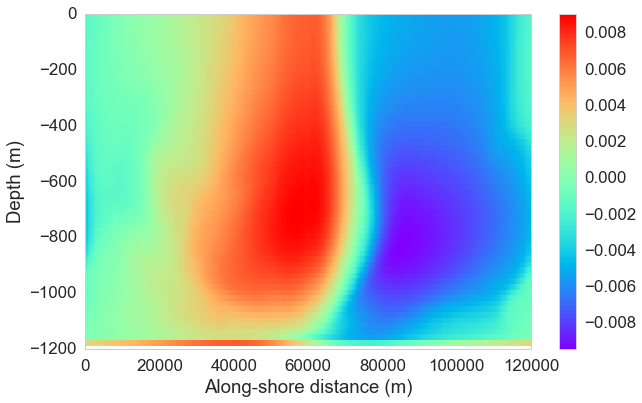

In [12]:
yi = 0
tt = 16

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})
field=np.ma.array(V[tt,:,1,:],mask=MaskS[:,1,:])
plt.pcolor(X[:],z[:],field,cmap = 'rainbow')
plt.colorbar()
plt.ylabel('Depth (m) ')
plt.xlabel('Along-shore distance (m)')

Awall = AreaWall(hFacS,drF,dxG,yi)
Transport = np.sum(Awall[:,:]*field)

print('Transport at ',tt, ' is ', Transport, 'm^3/s' )
#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



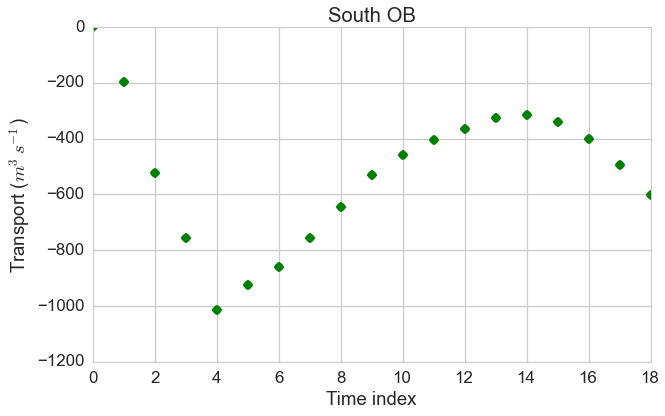

In [14]:
yi = 0
tt = 18

Awall = AreaWall(hFacS,drF,dxG,yi)
TransportSv = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])
    TransportSv[tt] = np.sum(Awall[:,:]*field)
    

plt.plot(TransportSv,'go')
plt.ylabel('Transport ($m^3s^{-1}$)')
plt.xlabel('Time index')

plt.title('South OB')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



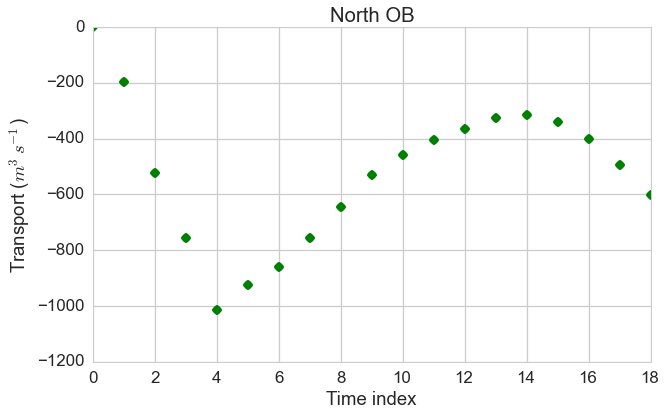

In [15]:
yi = 360

Awall = AreaWall(hFacS,drF,dxG,yi)
TransportNv = np.empty(19)

fig67=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])
    TransportNv[tt] = np.sum(Awall[:,:]*field)

plt.plot(TransportNv,'go')
plt.ylabel('Transport ($m^3s^{-1}$)')
plt.xlabel('Time index')

plt.title('North OB')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')


## Tracer transport through N and S OB

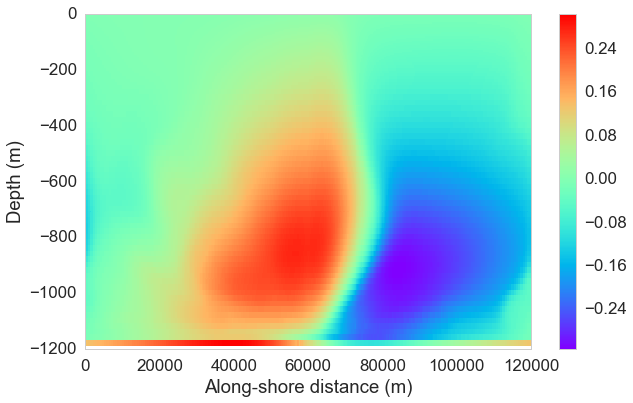

In [19]:
yi = 1
tt = 18

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})
field=np.ma.array(Tr1[tt,:,yi,:],mask=MaskC[:,yi,:])
vel=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])

plt.pcolor(X[:],z[:],field*vel,cmap = 'rainbow')
plt.colorbar()
plt.ylabel('Depth (m) ')
plt.xlabel('Along-shore distance (m)')

Awall = AreaWall(hFacS,drF,dxG,yi)
Transport = np.sum(Awall[:,:]*field*vel) 


#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



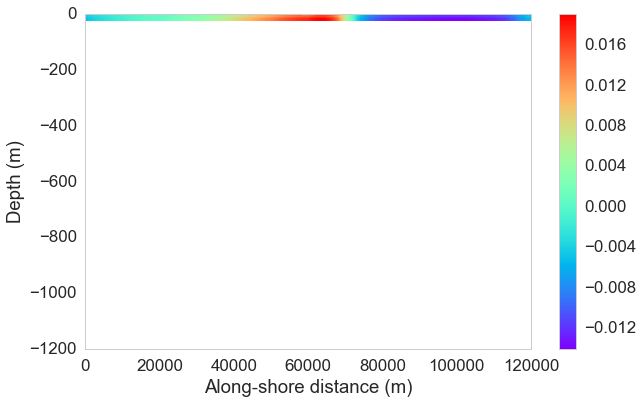

In [20]:
yi = 0
tt = 18

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})
field=np.ma.array(Tr1[tt,:,yi,:],mask=MaskC[:,yi,:])
vel=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])

plt.pcolor(X[:],z[:],field*vel,cmap = 'rainbow')
plt.colorbar()
plt.ylabel('Depth (m) ')
plt.xlabel('Along-shore distance (m)')

Awall = AreaWall(hFacS,drF,dxG,yi)
Transport = np.sum(Awall[:,:]*field*vel) 




Time integrated transport of tracer 1 through southern boundary is -9.773321e+11 mol


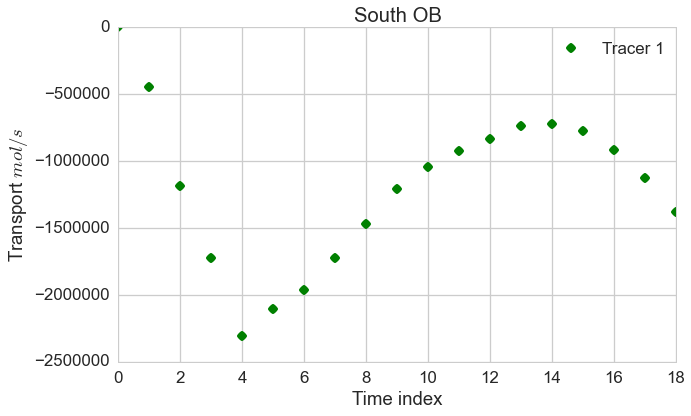

In [17]:
yi = 0
tt = 18

Awall = AreaWall(hFacS,drF,dxG,yi)
TransportSv1 = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field1=np.ma.array(Tr1[tt,:,yi,:],mask=MaskC[:,yi,:])
    
    vel=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])
    
    TransportSv1[tt] = np.sum(Awall[:,:]*field1*1000.0*vel) 
    
    

print('Time integrated transport of tracer 1 through southern boundary is %e mol' %(np.sum(TransportSv1)*12*3600))


plt.plot(TransportSv1,'go',label ='Tracer 1')

plt.ylabel('Transport $mol/s$')
plt.xlabel('Time index')
plt.legend()
plt.title('South OB')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



Time integrated transport of tracer 1 through northern boundary is -1.012484e+12 mol 


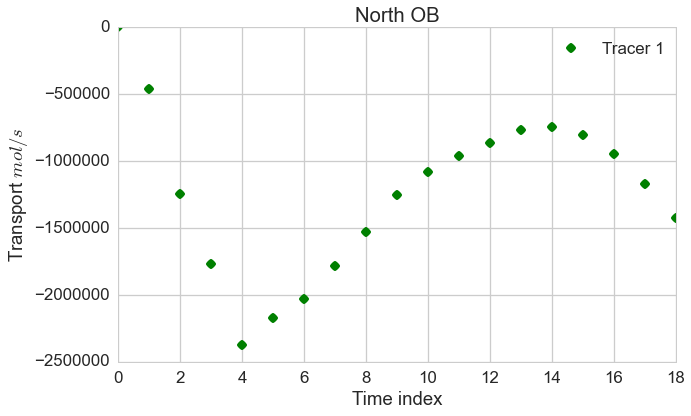

In [18]:
yi = 360
tt = 18

Awall = AreaWall(hFacS,drF,dxG,yi)
TransportNv1 = np.empty(19)


fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field1=np.ma.array(Tr1[tt,:,yi-1,:],mask=MaskC[:,yi-1,:])
   
    vel=np.ma.array(V[tt,:,yi,:],mask=MaskS[:,yi,:])
    
    TransportNv1[tt] = np.sum(Awall[:,:]*field1*1000.0*vel)
    

print('Time integrated transport of tracer 1 through northern boundary is %e mol ' %(np.sum(TransportNv1)*12*3600))



plt.plot(TransportNv1,'go',label ='Tracer 1')

plt.ylabel('Transport $mol/s$')
plt.xlabel('Time index')
plt.legend()
plt.title('North OB')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



## No canyon case - Tracer 

In [16]:
# run01
stateFile2='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/stateGlob.nc'
StateOut2 = Dataset(stateFile2)

gridFile2='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
GridOut2 = Dataset(gridFile2)
#for dimobj in GridOut.variables.values():
#    print dimobj
ptracersFile2='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'
PtracersOut2 = Dataset(ptracersFile2)


In [17]:
z2 = StateOut2.variables['Z']
Time2 = StateOut2.variables['T']

xc2 = rout.getField(gridFile2, 'XC') # x coords tracer cells
yc2 = rout.getField(gridFile2, 'YC') # y coords tracer cells

drF2 = GridOut2.variables['drF'] # vertical distance between faces

dxV2 = rout.getField(gridFile2,'dxV') # v - velocity separation dxV(Yp1, Xp1)
dxG2 = rout.getField(gridFile2,'dxG')

bathy2 = rout.getField(gridFile2, 'Depth')

rA2 = rout.getField(gridFile2, 'rA') # area of cells (x-y)
hFacC2 = rout.getField(gridFile2, 'HFacC')
MaskC2 = rout.getMask(gridFile2,'HFacC') # same for 3 runs


X2 = StateOut2.variables['X']
Y2 = StateOut2.variables['Y']
Xp12 = StateOut2.variables['Xp1']
Yp12 = StateOut2.variables['Yp1']


In [18]:
Tr12 = rout.getField(ptracersFile2,'Tr1') # [Tr#Run#] = mol/L = mol/dm^3
Tr22 = rout.getField(ptracersFile2,'Tr2') 
uu2 = rout.getField(stateFile2,'U') 
vv2 = rout.getField(stateFile2,'V') 

U2,V2 = rout.unstagger(uu2,vv2)

('Y =', 218.61183831892063)


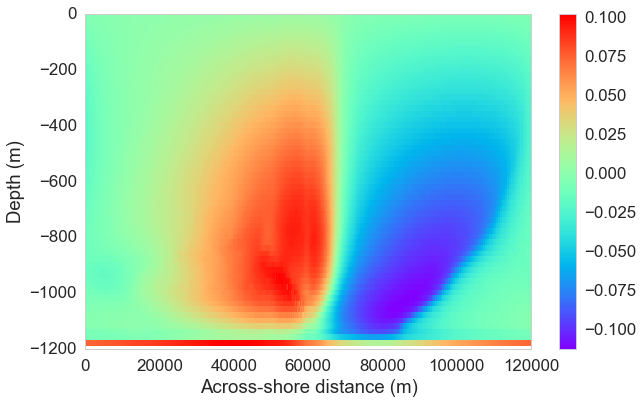

In [19]:
yi = 0
tt = 18

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})
field=np.ma.array(Tr12[tt,:,yi,:-1],mask=MaskC2[:,yi,:-1])
vel=np.ma.array(V2[tt,:,yi,:],mask=MaskC2[:,yi,:-1])

plt.pcolor(X2[:],z2[:],field*vel,cmap = 'rainbow')
plt.colorbar()
plt.ylabel('Depth (m) ')
plt.xlabel('Across-shore distance (m)')

print('Y =',  Y2[yi])


Awall = AreaWall(hFacC2,drF2,dxG2,yi)
Transport = np.sum(Awall[:,:-1]*field*vel) 



Y = 218.611838
Time integrated transport of tracer 1 through southern boundary is 6.082600e+09 mol
Time integrated transport of tracer 2 through southern boundary is 6.065431e+09 mol


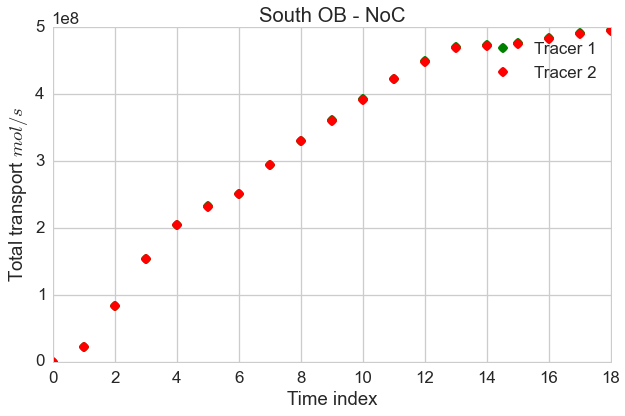

In [20]:
yi = 0
tt = 18

Awall = AreaWall(hFacC2,drF2,dxG2,yi)
TransportSvNoC1 = np.empty(19)
TransportSvNoC2 = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field1=np.ma.array(Tr12[tt,:,yi,:-1],mask=MaskC2[:,yi,:-1])
    field2=np.ma.array(Tr22[tt,:,yi,:-1],mask=MaskC2[:,yi,:-1])
    
    vel=np.ma.array(V2[tt,:,yi,:],mask=MaskC2[:,yi,:-1])
    
    TransportSvNoC1[tt] = np.sum(Awall[:,:-1]*field1*1000.0*vel) 
    TransportSvNoC2[tt] = np.sum(Awall[:,:-1]*field2*1000.0*vel)
    
print('Y = %f'  %Y2[yi])
print('Time integrated transport of tracer 1 through southern boundary is %e mol' %(np.sum(TransportSvNoC1)))
print('Time integrated transport of tracer 2 through southern boundary is %e mol' %(np.sum(TransportSvNoC2)))

plt.plot(TransportSvNoC1,'go',label ='Tracer 1')
plt.plot(TransportSvNoC2,'ro',label ='Tracer 2')
plt.ylabel('Total transport $mol/s$')
plt.xlabel('Time index')
plt.legend()
plt.title('South OB - NoC')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



Y = 89781.388162
Time integrated transport of tracer 1 through northern boundary is -1.021072e+07 mol 
Time integrated transport of tracer 2 through northern boundary is -1.012649e+07 mol


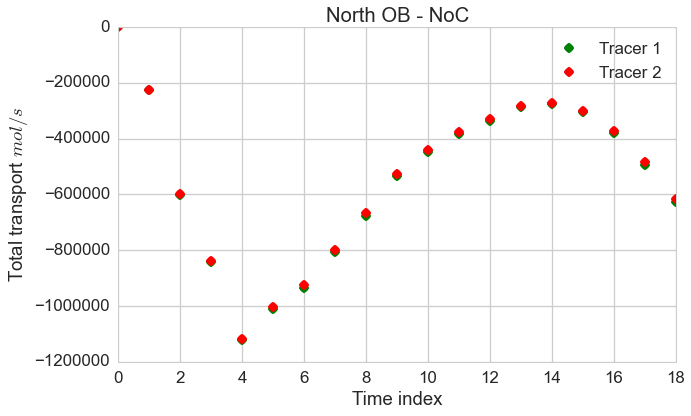

In [21]:
yi = 359
tt = 18

Awall = AreaWall(hFacC2,drF2,dxG2,yi)
TransportNvNoC1 = np.empty(19)
TransportNvNoC2 = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(19):
    field1=np.ma.array(Tr12[tt,:,yi,:-1],mask=MaskC2[:,yi,:-1])
    field2=np.ma.array(Tr22[tt,:,yi,:-1],mask=MaskC2[:,yi,:-1])
    
    vel=np.ma.array(V[tt,:,yi,:],mask=MaskC[:,yi,:-1])
    
    TransportNvNoC1[tt] = np.sum(Awall[:,:-1]*field1*1000.0*vel)
    TransportNvNoC2[tt] = np.sum(Awall[:,:-1]*field2*1000.0*vel)
    
print('Y = %f'  %Y[yi])
print('Time integrated transport of tracer 1 through northern boundary is %e mol ' %(np.sum(TransportNvNoC1)))
print('Time integrated transport of tracer 2 through northern boundary is %e mol' %(np.sum(TransportNvNoC2)))


plt.plot(TransportNv1,'go',label ='Tracer 1')
plt.plot(TransportNv2,'ro',label ='Tracer 2')
plt.ylabel('Total transport $mol/s$')
plt.xlabel('Time index')
plt.legend()
plt.title('North OB - NoC')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



## Using flux diagnostics

In [22]:
FluxTr01File1='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/FluxTR01Glob.nc'
FluxTr01Out1 = Dataset(FluxTr01File1)

ADVyTr1 = rout.getField(FluxTr01File1,'ADVyTr01') # [Tr#Run#] = mol/L = mol/dm^3
DFyETr1 = rout.getField(FluxTr01File1,'DFyETr01') # [Tr#Run#] = mol/L = mol/dm^3


Y = 218.611838
Time integrated flux (ADVy + DIFy) of tracer 1 through southern boundary is -6.808592e+11 mol


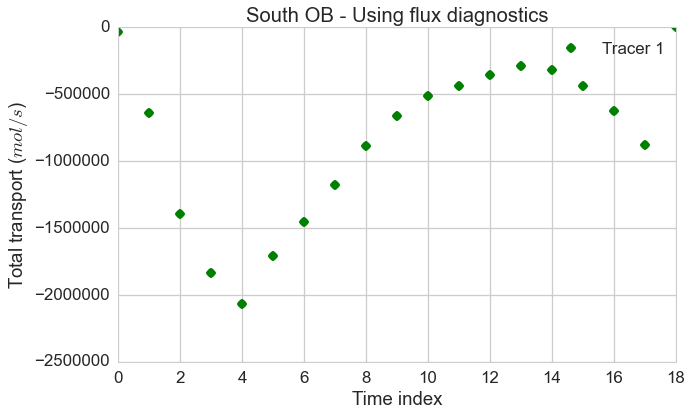

In [25]:
yi = 0


TransportSvFlux1 = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(18):
    
    TransportSvFlux1[tt] = np.sum((ADVyTr1[tt,:,yi,:] + DFyETr1[tt,:,yi,:])*1000.0 ) 
    
print('Y = %f'  %Y[yi])
print('Time integrated flux (ADVy + DIFy) of tracer 1 through southern boundary is %e mol' %(np.sum(TransportSvFlux1)*12*3600))

plt.plot(TransportSvFlux1,'go',label ='Tracer 1')

plt.ylabel('Total transport ($mol/s$)')
plt.xlabel('Time index')
plt.legend()
plt.title('South OB - Using flux diagnostics')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')



Y = 89781.388162
Time integrated flux (ADVy + DIFy) of tracer 1 through southern boundary is -7.172041e+09 mol


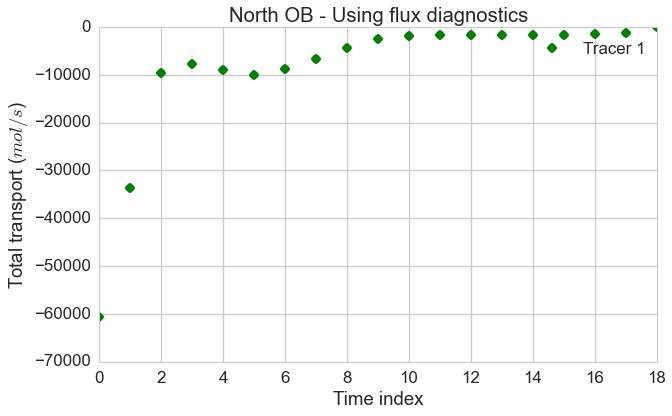

In [26]:
yi = 359
tt = 18

TransportNvFlux1 = np.empty(19)

fig66=plt.figure(figsize=(10,6))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1.3,rc={"lines.linewidth": 1.5})

for tt in np.arange(18):
    
    TransportNvFlux1[tt] = np.sum((ADVyTr1[tt,:,yi,:] + DFyETr1[tt,:,yi,:])*1000.0 ) 
    
print('Y = %f'  %Y[yi])
print('Time integrated flux (ADVy + DIFy) of tracer 1 through southern boundary is %e mol' %(np.sum(TransportNvFlux1)*12*3600))

plt.plot(TransportNvFlux1,'go',label ='Tracer 1')

plt.ylabel('Total transport ($mol/s$)')
plt.xlabel('Time index')
plt.legend()
plt.title('North OB - Using flux diagnostics')

#fig66.savefig('/ocean/kramosmu/Figures/.eps', format='eps', dpi=1000, bbox_inches='tight')

